In [66]:
'''Splits a large image into subimages of equal size (have to give it a number of subimages to split into).

For each subimage:
1. Performs Otsu threshold and uses results to determine blocksize and iterations.
2. Performs adaptive thresholding using selected blocksize and iterations. Removes noise.
3. Calculates a score for the result based on scale size variation and uniformity of distribution (currently not using overlap/fullness/squareness).
The lower the score, the better.
4. If the score is too high, repeat steps 1-3 on inverted image and see if the score for the inverted image is lower. Keep the one with lower score.

Finally, choose the 3 subimages with the lowest (best) scores (printed in a list at the bottom as SELECTED SUBIMAGES)
'''

# TODO:
# How to decide how many times to slice an image? - currently deciding based on the count from whole image
# Currently checks don't work if there's less than 3 scales (because standard deviation requires 2 data points, so we need at least 2 distances for distribution function)
# Checks get confused when there are too few non-edge scales
# Inversion is risky cause sometimes accidentally inverts an image that was fine
# Figure out whether dividing the standard deviation by the mean (in scale_size_variation function) makes any sense - appears to work??
# Currently scale size variation and distribution are weighted equally - look into whether this should be adjusted
# Does final output need to be number of scales per some unit? Trying to automatically read the scale bar is too hard...


'Splits a large image into subimages of equal size (have to give it a number of subimages to split into).\n\nFor each subimage:\n1. Performs Otsu threshold and uses results to determine blocksize and iterations.\n2. Performs adaptive thresholding using selected blocksize and iterations. Removes noise.\n3. Calculates a score for the result based on scale size variation and uniformity of distribution (currently not using overlap/fullness/squareness).\nThe lower the score, the better.\n4. If the score is too high, repeat steps 1-3 on inverted image and see if the score for the inverted image is lower. Keep the one with lower score.\n\nFinally, choose the 3 subimages with the lowest (best) scores (printed in a list at the bottom as SELECTED SUBIMAGES)\n'

In [67]:
import cv2
import numpy as np
from datascience import *
import matplotlib as mpl
from matplotlib import pyplot as plt
import sys
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 120
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import pandas
import statistics
import image_slicer

In [68]:
def threshold_otsu(img):
    '''Parameter img should already have been read by cv2 and converted to grayscale.
    Returns sure foreground of image thresholded using Otsu.'''
    # Apply blur
    blur = cv2.GaussianBlur(img,(5,5),0)
    
    # Threshold image using Otsu
    ret, thresh = cv2.threshold(blur,0 , 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Perform opening on thresholded image
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 4)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform, 1.5, 255, 0)
    
    return sure_fg

In [69]:
def choose_blocksize_and_iterations(img):
    '''Parameter img should be the sure foreground of the Otsu-thresholded image.
    Returns selected blocksize and iterations.'''
    
    # Collect stats from image
    binary_map = (img > 0).astype(np.uint8)
    connectivity = 4 # can be changed
    output = cv2.connectedComponentsWithStats(binary_map, connectivity, cv2.CV_32S)
   
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    
    avg_scale_size = np.average(stats[1:,-1])
    
    if num_labels <= 3:
        return 15, 1
    elif avg_scale_size < 350:
        return 65, 2
    elif avg_scale_size < 550:
        return 65, 3
    else:
        return 85, 1

In [70]:
def threshold_adaptive(img, blocksize, iterations):
    '''Parameter img should already have been read by cv2 and converted to grayscale.
    Performs adaptive thresholding on img using given blocksize and iterations.
    Returns resulting:
        -sure foreground with noise (for displaying purposes)
        -noise-removed image with scales labeled
        -scale count'''
    if (blocksize > 15):
        blur = cv2.GaussianBlur(img,(5,5),1)
        blur = cv2.bilateralFilter(blur,10,10,100)
    else:
        blur = cv2.GaussianBlur(img,(5,5),0)

    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blocksize, -2)

    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations=iterations)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform, 1.5, 255, 0) 

    # Collect stats from sure_foreground image
    binary_map = (sure_fg > 0).astype(np.uint8)
    connectivity = 4 # can be changed
    output = cv2.connectedComponentsWithStats(binary_map, connectivity, cv2.CV_32S)
   
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    
    scale_sizes = np.copy(stats[1:,-1]) # start from 1 instead of 0 to ignore background, use copy so that stats array doesn't get modified
    scale_sizes.sort() # sort the list of scale sizes from smallest to largest
    avg_scale_size = np.average(scale_sizes[len(scale_sizes) // 2:]) # average size among the largest half of the scales
    
    # Removing noise
    for i in range(num_labels):
        # If a scale is smaller than 1/10 the average among the largest half of the scales
        if stats[i, cv2.CC_STAT_AREA] < (avg_scale_size / 10):
            noise_left = stats[i, cv2.CC_STAT_LEFT]
            noise_top = stats[i, cv2.CC_STAT_TOP]
            # Go through the bounding box of the noise and find all the pixels that are part of the noise
            for x in range(noise_left, noise_left + stats[i, cv2.CC_STAT_WIDTH]):
                for y in range(noise_top, noise_top + stats[i, cv2.CC_STAT_HEIGHT]):
                    if labels[y][x] == i: # If the pixel is part of the noise
                        labels[y][x] = 0 # Remove the noise by replacing the pixel with the background label
            num_labels -= 1
    # Note: Noise has been removed from labels matrix, but the noise is still in stats/centroids matrices.
    # This is ok because we don't use these outdated stats/centroids matrices again (in later functions, we create updated stats matrices by calling connected components again on the noise-removed image.)
    
    # Label and count
    # source: https://medium.com/analytics-vidhya/images-processing-segmentation-and-objects-counting-in-an-image-with-python-and-opencv-216cd38aca8e
    label_hue = np.uint8(179 * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0
    
    return sure_fg, labeled_img, num_labels - 1 # background doesn't count as a scale

In [71]:
def display_results_orig(orig, with_noise, noise_removed, count):
    plt.subplot(1,3,1), plt.imshow(orig, 'gray')
    plt.title("Orginal Grayscale", fontsize=5)
    plt.subplot(1,3,2), plt.imshow(with_noise, 'gray')
    plt.title("With Noise", fontsize=5)
    plt.subplot(1,3,3), plt.imshow(noise_removed, 'gray')
    plt.title("Noise-Removed, Count = " + str(count), fontsize=5)
    plt.show()

def display_results_invert(orig, invert, with_noise, noise_removed, count):
    plt.subplot(1,4,1), plt.imshow(orig, 'gray')
    plt.title("Orginal Grayscale", fontsize=5)
    plt.subplot(1,4,2), plt.imshow(invert, 'gray')
    plt.title("Inverted", fontsize=5)
    plt.subplot(1,4,3), plt.imshow(with_noise, 'gray')
    plt.title("Inverted With Noise", fontsize=5)
    plt.subplot(1,4,4), plt.imshow(noise_removed, 'gray')
    plt.title("Inverted Noise-Removed, Count = " + str(count), fontsize=5)
    plt.show()

In [72]:
def calculate_score(img):
    '''Parameter img should already have scales labeled.
    Calculates and returns score based on average scale size variation and uniformity of scale distribution.
    THE LOWER THE SCORE, THE BETTER.'''
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binary_map = (img > 0).astype(np.uint8) # make the labeled image binary (make everything that is not black be white)
    
    # we need to collect new data on connected components (rather than using previous stats array) because the noise-removal method in threshold_custom changed the image but not the stats array
    output = cv2.connectedComponentsWithStats(binary_map, 4, cv2.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    
    # if there's less than 3 scales (num_labels = num_scales + 1 b/c of background), the checks won't work because standard deviation requires at least 2 points (two distances for distribution function)
    # Result is probably bad if there's zero or 1 scale, but I'm not sure about 2...
    if num_labels <= 3:
        print("Cannot check quality of result because less than 3 scales were found.")
        return 100 #this is a random high value I chose to show that the result is not good
    
    size_var = scale_size_variation(num_labels, stats, len(img), len(img[0]))
    dis = distribution(num_labels, centroids)
    
    #Decided not to use overlap/fullness/squareness, but kept them here in comments just in case
    #overlap = overlap_of_bounds(num_labels, stats, len(img), len(img[0])) #bounding box overlap not that useful - maybe only use to eliminate if extremely high, like > 1?
    #fullness, squareness = fullness_and_squareness(num_labels, stats, len(img), len(img[0]))
    
    print("Size variation: " + str(size_var))
    #print("Overlap: " + str(overlap))
    #print("Fullness: " + str(fullness))
    #print("Squareness: " + str(squareness))
    print("Distribution: " + str(dis))
    
    score = (size_var + dis) / 2 # score is the average of size variation and distribution
    print("Overall score: " + str(score))

    return score

    
def bounding_box_edges(i, stats):
    '''Returns coordinates of edges of the bounding box at index i in stats array'''
    left = stats[i, cv2.CC_STAT_LEFT]
    right = left + stats[i, cv2.CC_STAT_WIDTH] - 1
    top = stats[i, cv2.CC_STAT_TOP]
    bottom = top + stats[i, cv2.CC_STAT_HEIGHT] - 1
    return left, right, top, bottom
        
def scale_size_variation(num_labels, stats, img_len, img_width):
    '''Returns average variation in scale size, calculated without edge scales (except in the case where there are not enough non-edge scales).
    High variation likely corresponds to poor quality results.
    Result is considered very good if return value is less than 1.
    Only works if there is at least 2 scales.''' # add assertion error check for this?
    scale_areas = []
    edge_scale_areas = []
    for i in range(1, num_labels): # start at 1 to ignore background
        
        # don't consider scales that touch the edge
        left, right, top, bottom = bounding_box_edges(i, stats)
        if left == 0 or top == 0 or right == img_width - 1 or bottom == img_len - 1:
            edge_scale_areas.append(stats[i, cv2.CC_STAT_AREA].astype(int))
            continue
            
        scale_areas.append(stats[i, cv2.CC_STAT_AREA].astype(int))

    # if 1 or zero non-edge scales, then use edge scales in calculation (otherwise, do not use edge scales)
    if len(scale_areas) < 2:
        scale_areas = scale_areas + edge_scale_areas
        
    stddev = statistics.stdev(scale_areas)
    mean = sum(scale_areas) / len(scale_areas)
    #print("(Std dev / mean) for scale area: " + str(stddev / mean))

    for edge_scale_area in edge_scale_areas: # if any of the edge scales are more than five times the average size of the non-edge scales, this is bad
        if edge_scale_area > 5*mean:
            print("Found an edge scale that is more than 5 times the average size of non-edge scales.")
            return 100 # this is bad so return a really high value

    # thresholding good if return value less than 1
    return (stddev / mean) # figure out if dividing by mean makes any sense

def distribution(num_labels, centroids):
    '''Calculates and returns the standard deviation of the distances between the centroids of neighboring scales.
    The lower the return value, the more uniform the distribution of scales.
    Only works if there is at least 3 scales (2 distances to compare)''' # add assertion error check for this?
    x_values = []
    y_values = []
    for i in range(1, num_labels):
        x_values.append(centroids[i, 0])
        y_values.append(centroids[i, 1])
    x_values.sort()
    y_values.sort()
    
    x_diff = []
    y_diff = []
    for i in range(1, len(x_values)):
        x_diff.append(x_values[i] - x_values[i-1]) # differences between neighboring x-coordinates
        y_diff.append(y_values[i] - y_values[i-1]) # differences between neighboring y-coordinates
    
    x_stddev = statistics.stdev(x_diff)
    y_stddev = statistics.stdev(y_diff)
    avg_stddev = (x_stddev + y_stddev) / 2
    return avg_stddev

# ***Currently not used***
# Not used because most images have little overlap of bounds, regardless of how good the thresholding is
def overlap_of_bounds(num_labels, stats, img_len, img_width):
    '''Returns average overlap of the bounding boxes of the scales.
    More overlap suggests that the identified scales are not localized; rather, they weave around one another.
    Result is considered good if return value is less than 0.63.'''
    if num_labels < 2: # return None if no scales
        return
    #check for overlappingness of bounding boxes
    overlap_array = np.zeros((img_len, img_width))
    for i in range(1, num_labels): # start at 1 to ignore background
        left, right, top, bottom = bounding_box_edges(i, stats)
        for r in range(top, bottom + 1):
            for c in range(left, right + 1):
                overlap_array[r, c] += 1
    avg_overlap = np.average(overlap_array)
    #print("Avg bounding box overlap: " + str(avg_overlap))
    percent_overlap = np.count_nonzero(overlap_array > 1) / np.size(overlap_array)
    
    # thresholding good if return value less than 0.63
    return avg_overlap

# ***Currently not used***
# Produces inconsistent results (often wrong)
def fullness_and_squareness(num_labels, stats, img_len, img_width):
    '''Returns average fullness and squareness of the scales.
    Fullness is the ratio of the area of the scale to the area of the bounding box.
    Squareness is the ratio width:length of the bounding box.
    Greater fullness suggests that the scale is solid and full rather than webbed or full of holes.
    Greater squareness suggests that the scale is square/circular rather than long and skinny.
    Results considered good if fullness > 0.7 and squareness > 0.5.'''
    squareness = []
    fullness = []
    for i in range(1, num_labels):
        
        left, right, top, bottom = bounding_box_edges(i, stats)
        # don't consider scales that touch the edge
        if left == 0 or top == 0 or right == img_width - 1 or bottom == img_len - 1:
            continue
            
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        squareness.append(min(w, h) / max(w, h)) # closer to 1 means more square, smaller than 1 means less square
        
        scale_area = stats[i, cv2.CC_STAT_AREA]
        box_area = w * h
        fullness.append(scale_area / box_area)
    if fullness:
        avg_fullness = sum(fullness) / len(fullness)
        #print("Avg fullness: " + str(avg_fullness))
        squareness.sort()
        least_square = squareness[:10]
        avg_squareness = sum(least_square) / len(least_square)
        #print("Avg squareness of 10 least square scales: " + str(avg_squareness))
    
        # thresholding good if fullness > 0.7 and squareness > 0.5
        return avg_fullness, avg_squareness
    else:
        return None, None
    # returns None if no non-edge scales

In [73]:
def compare_results(score_list, num_to_keep):
    '''Compares the scores from different thresholding attempts and returns the indices corresponding to the best one(s).
    The second return value is a boolean indicating whether the best result passes a quality-check.
    Parameters: score_list is a list of scores for each image from calculate_score,
    num_to_keep is the number of images that we want to keep.'''
    
    # Return the indices corresponding to the best results - remember, the lower the score, the better
    best_indices = []
    for i in range(len(score_list)):
        if len(best_indices) < num_to_keep:
            best_indices.append(i)
        else:
            current_worst_score = max([score_list[i] for i in best_indices])
            if score_list[i] < current_worst_score: # if the score is better than the previous scores
                best_indices.remove(score_list.index(current_worst_score)) # remove the index corresponding to lowest score
                best_indices.append(i)
    
    # if any of the selected images have poor quality, say so
    for i in best_indices:
        if score_list[i] > 5: # if the score is too high (change this value later)
            print("Could not find " + str(num_to_keep) + " subimages that pass the quality check.")
        
    return best_indices

In [74]:
def invert(img):
    '''Inverts a grayscale image.'''
    return cv2.bitwise_not(img)

In [75]:
def count_scales(img):
    '''Parameter img must already have been read into cv2 and converted to grayscale.
    Calls threshold_otsu, then choose_blocksize_and_iterations, then threshold_adaptive.
    Returns resulting images and count.'''
    img_otsu = threshold_otsu(img)
    blocksize, iterations = choose_blocksize_and_iterations(img_otsu)
    print("Blocksize, iterations: " + str(blocksize) + ", " + str(iterations))
    with_noise, labeled_img, count = threshold_adaptive(img, blocksize, iterations)
    return with_noise, labeled_img, count

In [76]:
def call_count_scales_and_check_inversion(img):
    '''Main function that calls all the other functions.
    Parameter img should have already been read into cv2.
    Counts scales on original image, checks result, and counts scales on inverted image if needed.
    Finally, compares results from original vs. inverted image, and displays results from the better one.'''
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    print("Original Image:")
    # count scales on original image
    orig_with_noise, orig_labeled_img, orig_count = count_scales(img)
    
    # check how good the results are
    orig_score = calculate_score(orig_labeled_img)
    
    # If the result is good, display results and finish
    if orig_score < 3:
        print("\nOriginal image passed all tests; did not need to check inverted.")
        display_results_orig(img, orig_with_noise, orig_labeled_img, orig_count)
        return orig_count, orig_score

    # Otherwise, try inverted image and compare results to original
    else:
        # invert image
        inverted_img = invert(img)
    
        # count scales on inverted image
        print('\nInverted Image:')
        inv_with_noise, inv_labeled_img, inv_count = count_scales(inverted_img)
    
        # check how good the new results are
        inverted_score = calculate_score(inv_labeled_img)
        score_list = [orig_score, inverted_score]
        
        # compare the results from original and inverted images
        best_index = compare_results(score_list, 1)
        best_index = best_index[0]
    
        if best_index == 0:
            print("\nTried both original and inverted, but decided to keep original.")
            display_results_orig(img, orig_with_noise, orig_labeled_img, orig_count)
            best_count = orig_count
        elif best_index == 1:
            print("\nDECIDED TO USE INVERTED IMAGE.")
            display_results_invert(img, inverted_img, inv_with_noise, inv_labeled_img, inv_count)
            best_count = inv_count
        
        return best_count, score_list[best_index] # return count and score

In [77]:
def run_count_on_directory(dirname):
    '''Calls call_count_scales_and_check_inversion function on every image in the given directory.'''
    directory = os.scandir(dirname)
    
    for img in directory:
        if (img.name == '.ipynb_checkpoints' or img.name == '.DS_Store'): # need to figure how to remove these files
            continue
        img_names.append(img.name)
        img_arr = cv2.imread(dirname + img.name)
        count, score_list = call_count_scales_and_check_inversion(img_arr)

    #table = Table().with_columns("Img Name", img_names, "Number of Scales", count_list, "Passes Quality Check?", quality_list)
    #table.show()
    

In [78]:
def split_count_select(img_path, num_to_keep):
    '''Splits given image into subimages and selects best ones to keep. '''
    img = cv2.imread(img_path)
    print('INITIALLY COUNTING ENTIRE IMAGE IN ORDER TO DETERMINE NUMBER OF SUBIMAGES TO USE:\n')
    count, score = call_count_scales_and_check_inversion(img)
    num_subimages = count // 20 + 1
    print('Decided to split image into ' + str(num_subimages) + ' subimages.\n')
    tiles = image_slicer.slice(img_path, num_subimages)
    all_scores = []
    i = 0
    for tile in tiles:
        print('SUBIMAGE #' + str(i) + ':\n')
        count, score_list = call_count_scales_and_check_inversion(np.asarray(tile.image))
        all_scores.append(score_list)
        i += 1
    best_indices_lst = compare_results(all_scores, num_to_keep)
    print('\nSELECTED SUBIMAGES: ' + str(best_indices_lst))

INITIALLY COUNTING ENTIRE IMAGE IN ORDER TO DETERMINE NUMBER OF SUBIMAGES TO USE:

Original Image:
Blocksize, iterations: 65, 2
Found an edge scale that is more than 5 times the average size of non-edge scales.
Size variation: 100
Distribution: 1.1796071376885995
Overall score: 50.5898035688443

Inverted Image:
Blocksize, iterations: 65, 3
Found an edge scale that is more than 5 times the average size of non-edge scales.
Size variation: 100
Distribution: 2.993850797887074
Overall score: 51.49692539894354
Could not find 1 subimages that pass the quality check.

Tried both original and inverted, but decided to keep original.


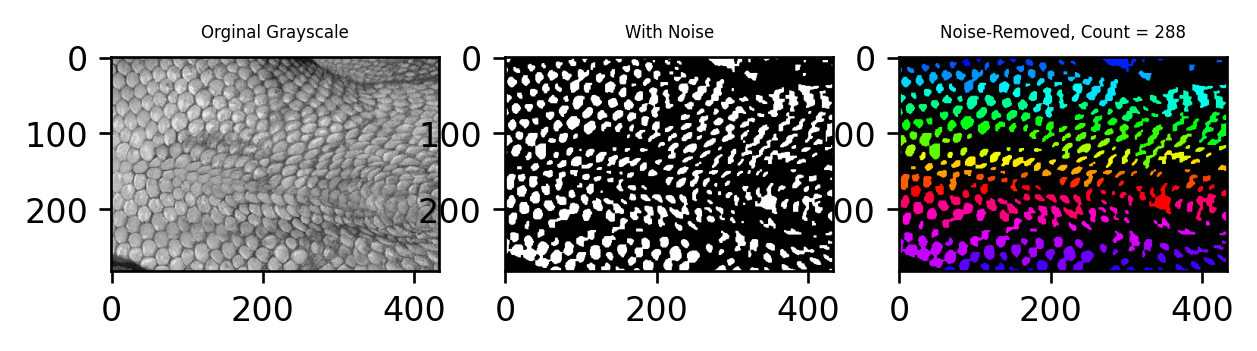

Decided to split image into 15 subimages.

SUBIMAGE #0:

Original Image:
Blocksize, iterations: 65, 2
Size variation: 0.4082998326561359
Distribution: 2.572288445230029
Overall score: 1.4902941389430826

Original image passed all tests; did not need to check inverted.


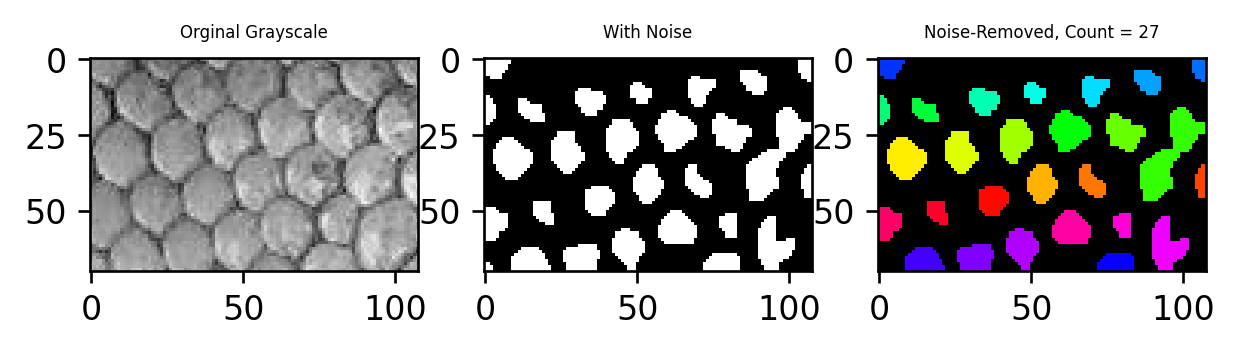

SUBIMAGE #1:

Original Image:
Blocksize, iterations: 65, 2
Size variation: 0.5179305089941741
Distribution: 2.1000982877673993
Overall score: 1.3090143983807867

Original image passed all tests; did not need to check inverted.


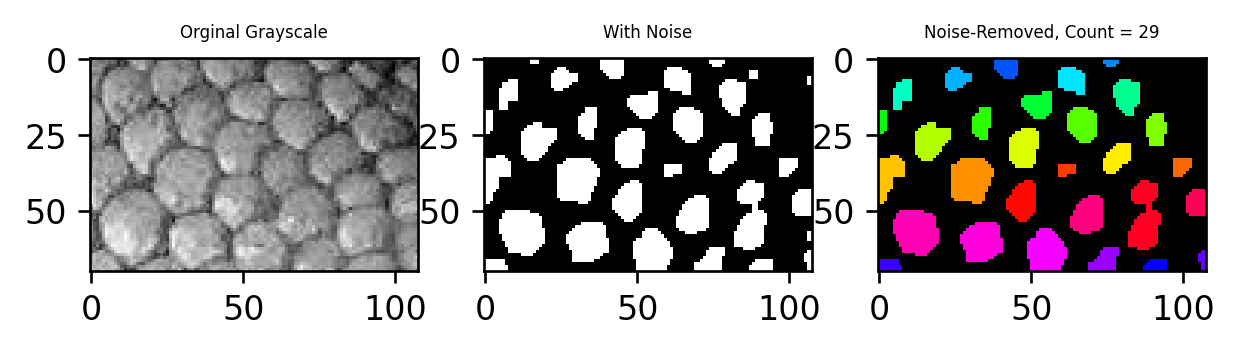

SUBIMAGE #2:

Original Image:
Blocksize, iterations: 65, 2
Size variation: 0.8119132730474341
Distribution: 4.882248467941134
Overall score: 2.8470808704942843

Original image passed all tests; did not need to check inverted.


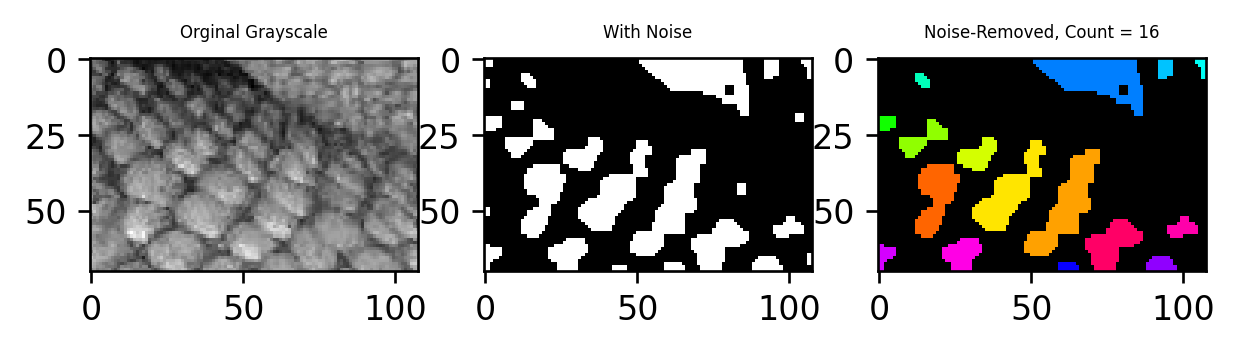

SUBIMAGE #3:

Original Image:
Blocksize, iterations: 65, 2
Size variation: 1.2520890405112726
Distribution: 5.908239801907651
Overall score: 3.580164421209462

Inverted Image:
Blocksize, iterations: 65, 2
Found an edge scale that is more than 5 times the average size of non-edge scales.
Size variation: 100
Distribution: 10.026051290801856
Overall score: 55.01302564540093

Tried both original and inverted, but decided to keep original.


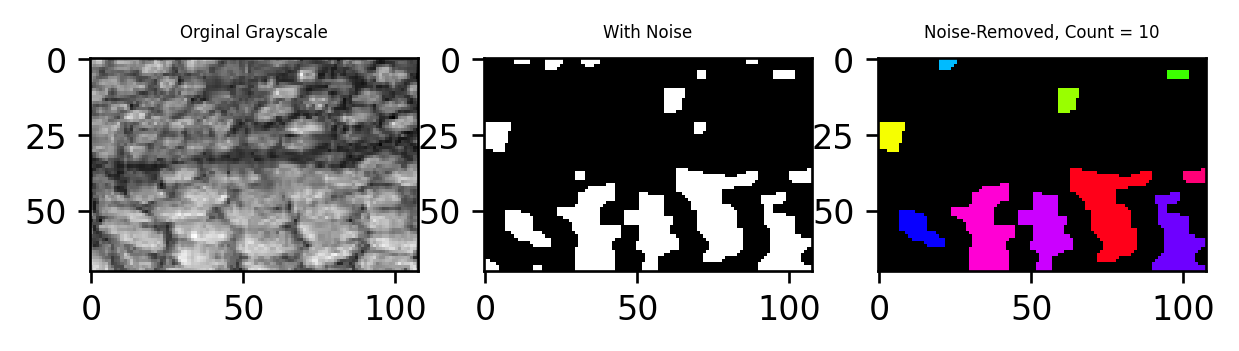

SUBIMAGE #4:

Original Image:
Blocksize, iterations: 65, 2
Size variation: 0.8761791519703916
Distribution: 2.715545793018694
Overall score: 1.7958624724945427

Original image passed all tests; did not need to check inverted.


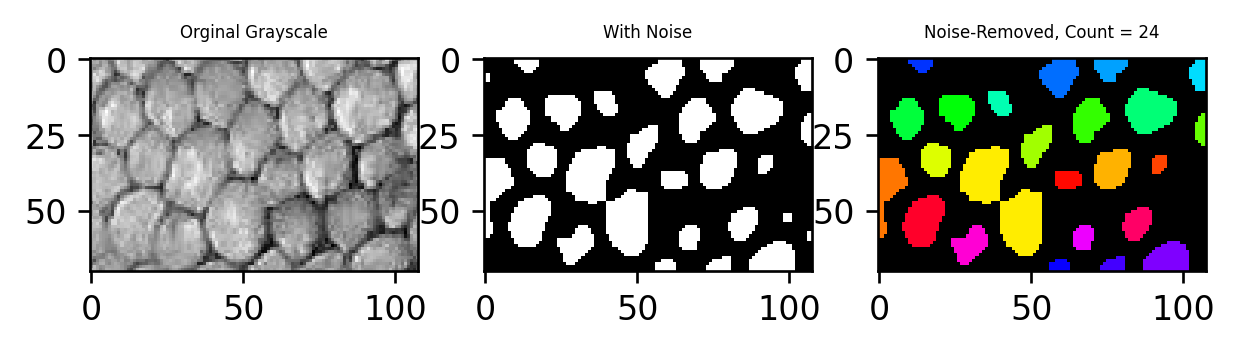

SUBIMAGE #5:

Original Image:
Blocksize, iterations: 65, 2
Size variation: 0.7257296694698011
Distribution: 3.02399370619863
Overall score: 1.8748616878342157

Original image passed all tests; did not need to check inverted.


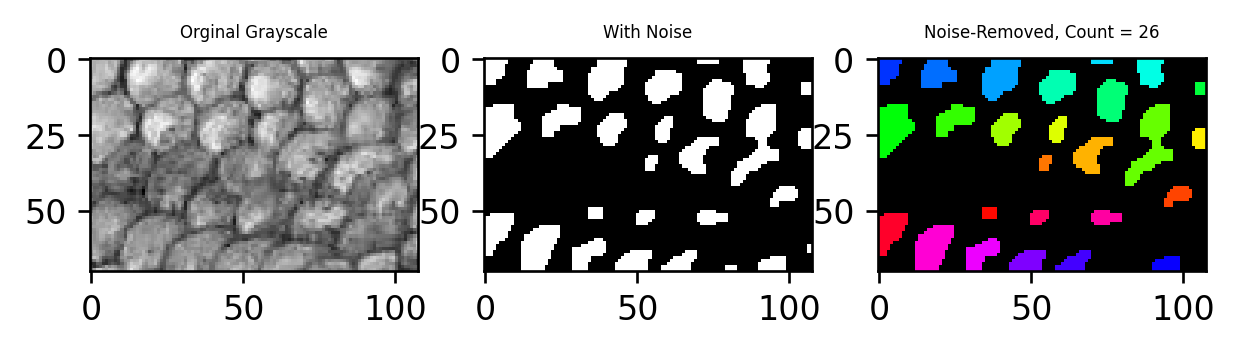

SUBIMAGE #6:

Original Image:
Blocksize, iterations: 65, 2
Size variation: 0.6008715510878018
Distribution: 3.35096744928512
Overall score: 1.975919500186461

Original image passed all tests; did not need to check inverted.


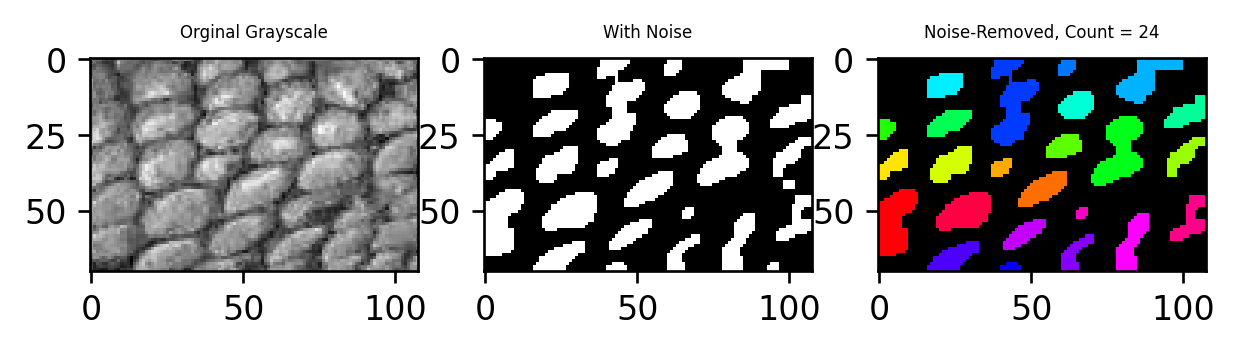

SUBIMAGE #7:

Original Image:
Blocksize, iterations: 65, 2
Size variation: 0.8515933306798263
Distribution: 3.474212303078316
Overall score: 2.162902816879071

Original image passed all tests; did not need to check inverted.


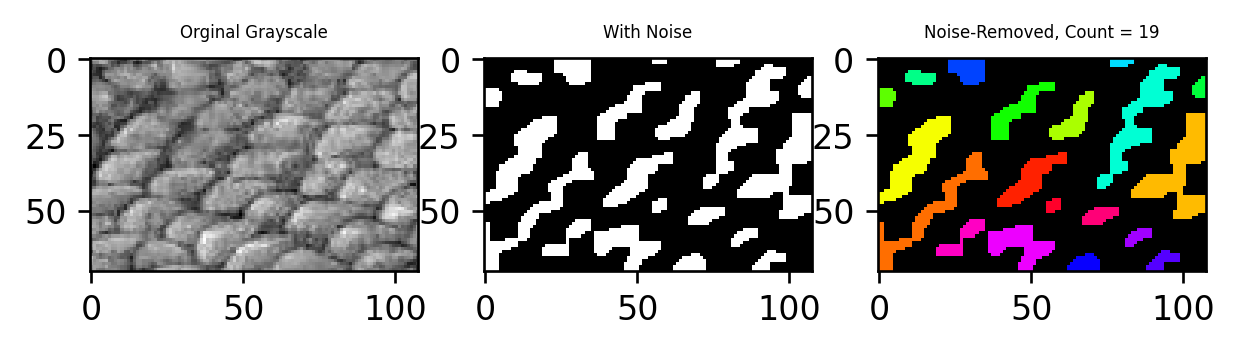

SUBIMAGE #8:

Original Image:
Blocksize, iterations: 65, 2
Size variation: 0.4459630664535181
Distribution: 2.7815459979680055
Overall score: 1.6137545322107618

Original image passed all tests; did not need to check inverted.


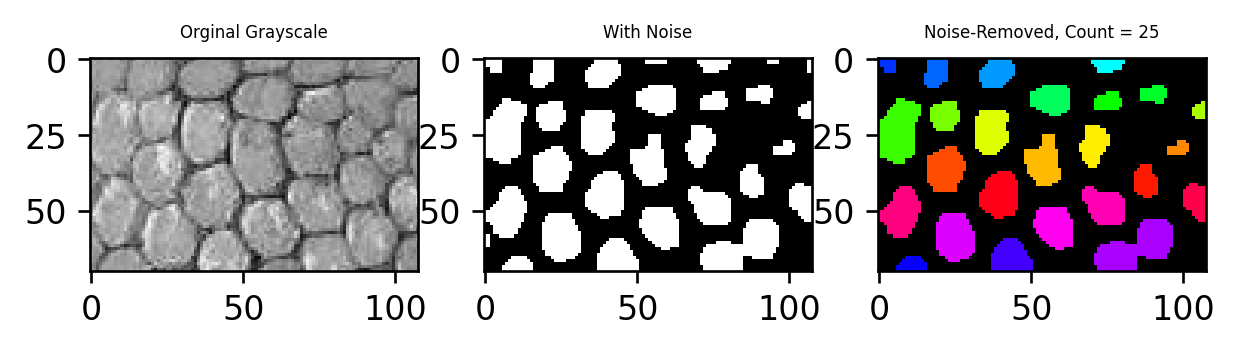

SUBIMAGE #9:

Original Image:
Blocksize, iterations: 65, 2
Size variation: 0.721977537770223
Distribution: 3.0989053732969154
Overall score: 1.9104414555335691

Original image passed all tests; did not need to check inverted.


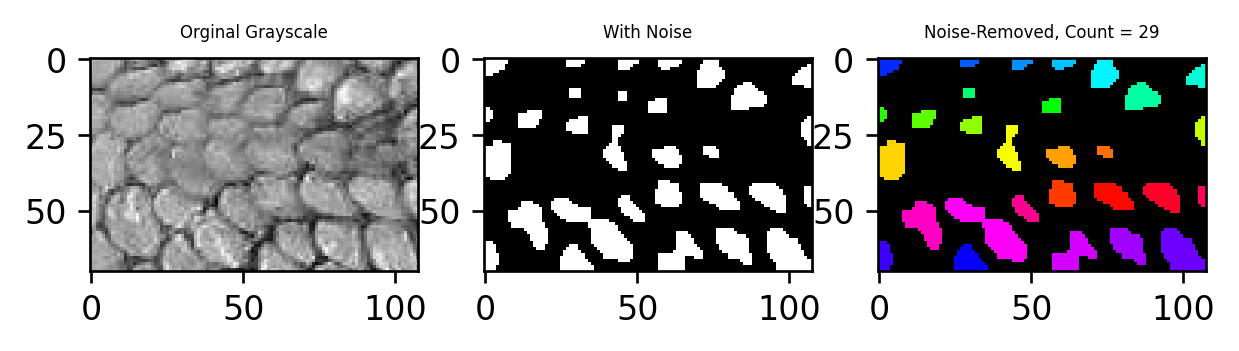

SUBIMAGE #10:

Original Image:
Blocksize, iterations: 65, 2
Size variation: 0.5244530123244762
Distribution: 2.765030698701126
Overall score: 1.6447418555128013

Original image passed all tests; did not need to check inverted.


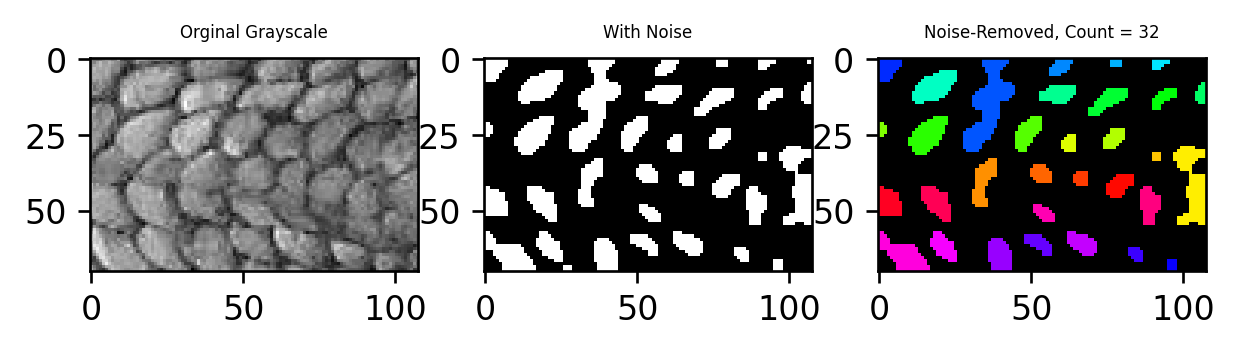

SUBIMAGE #11:

Original Image:
Blocksize, iterations: 65, 2
Size variation: 1.4714142744909953
Distribution: 4.356468596165559
Overall score: 2.9139414353282773

Original image passed all tests; did not need to check inverted.


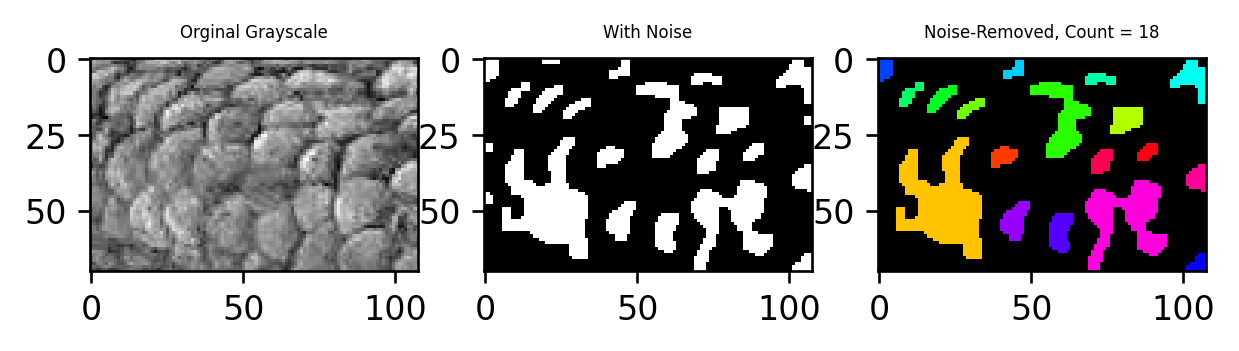

SUBIMAGE #12:

Original Image:
Blocksize, iterations: 85, 1
Size variation: 1.5510578968018724
Distribution: 7.873311022699239
Overall score: 4.7121844597505556

Inverted Image:
Blocksize, iterations: 15, 1
Found an edge scale that is more than 5 times the average size of non-edge scales.
Size variation: 100
Distribution: 3.383564741485853
Overall score: 51.69178237074293

Tried both original and inverted, but decided to keep original.


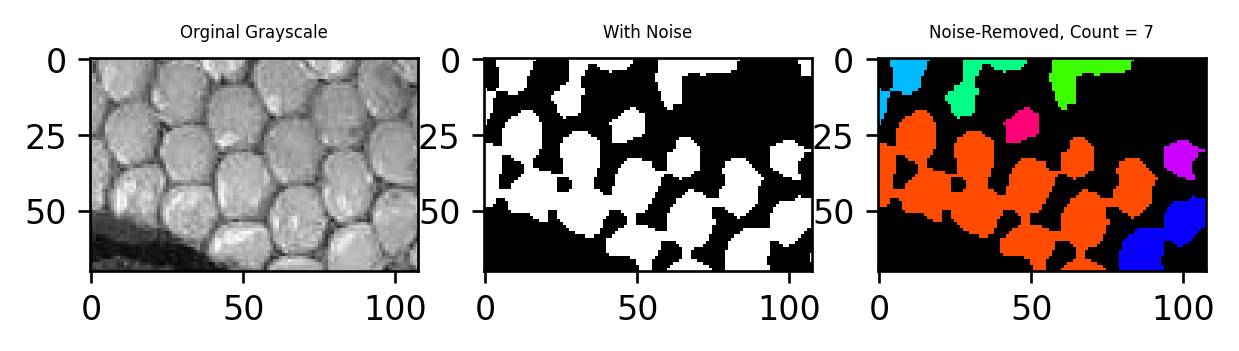

SUBIMAGE #13:

Original Image:
Blocksize, iterations: 65, 2
Size variation: 0.6502485628970137
Distribution: 3.791860050530013
Overall score: 2.2210543067135133

Original image passed all tests; did not need to check inverted.


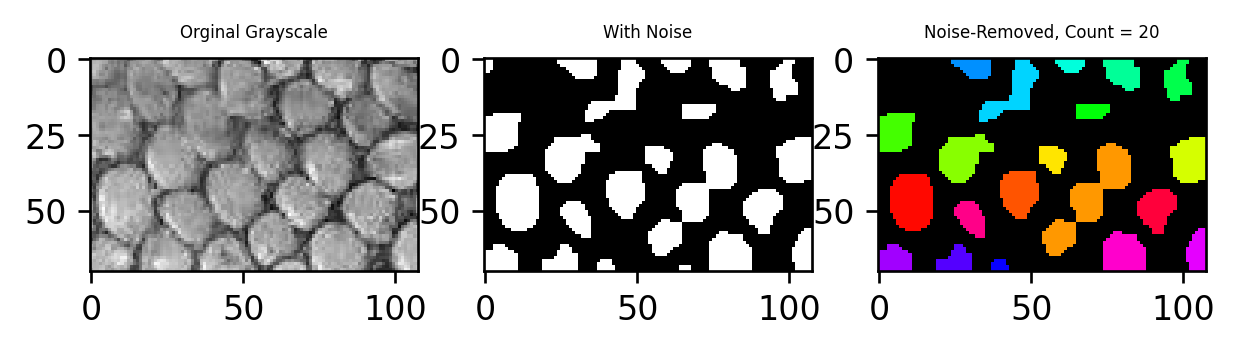

SUBIMAGE #14:

Original Image:
Blocksize, iterations: 65, 2
Size variation: 0.7482447014289656
Distribution: 3.5733306789653327
Overall score: 2.1607876901971492

Original image passed all tests; did not need to check inverted.


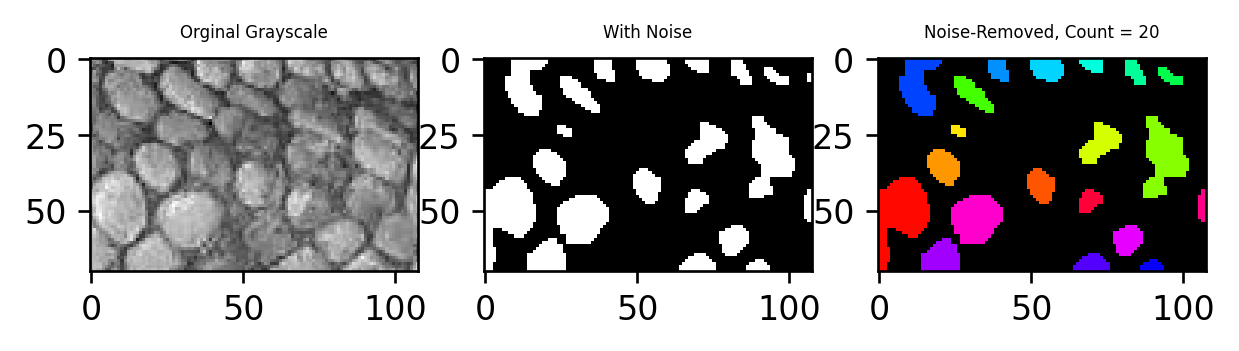

SUBIMAGE #15:

Original Image:
Blocksize, iterations: 65, 2
Size variation: 0.6467305176139397
Distribution: 4.413646085714495
Overall score: 2.5301883016642175

Original image passed all tests; did not need to check inverted.


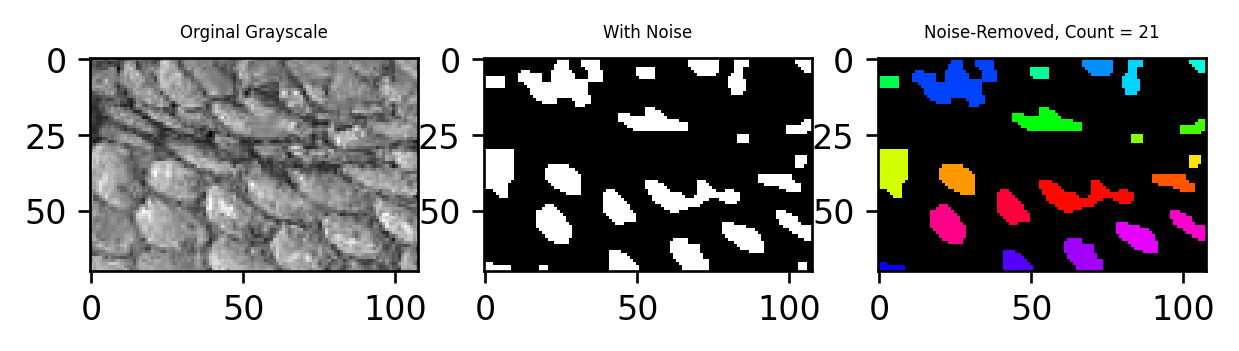


SELECTED SUBIMAGES: [0, 1, 8]


In [79]:
img_path = 'Large_images/135161_V_large_sample.png'
split_count_select(img_path, 3)

INITIALLY COUNTING ENTIRE IMAGE IN ORDER TO DETERMINE NUMBER OF SUBIMAGES TO USE:

Original Image:
Blocksize, iterations: 85, 1
Found an edge scale that is more than 5 times the average size of non-edge scales.
Size variation: 100
Distribution: 3.13093621020114
Overall score: 51.56546810510057

Inverted Image:
Blocksize, iterations: 85, 1
Found an edge scale that is more than 5 times the average size of non-edge scales.
Size variation: 100
Distribution: 7.748107874884755
Overall score: 53.874053937442376
Could not find 1 subimages that pass the quality check.

Tried both original and inverted, but decided to keep original.


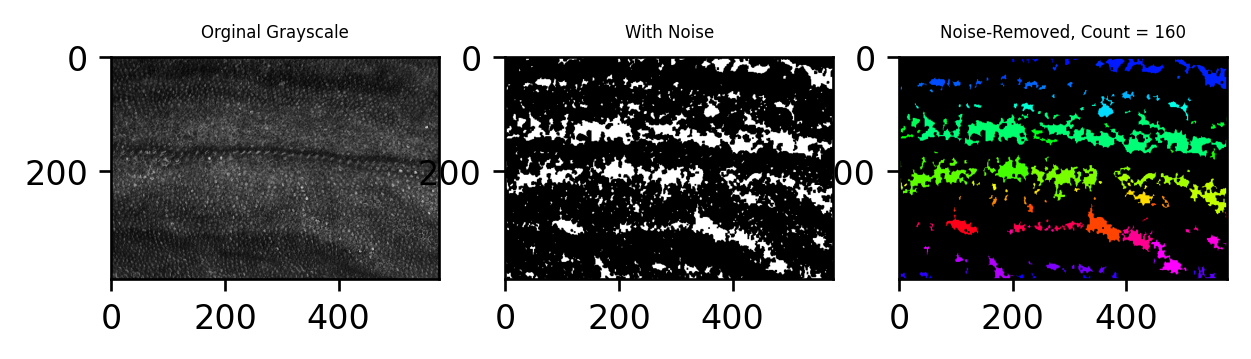

Decided to split image into 9 subimages.

SUBIMAGE #0:

Original Image:
Blocksize, iterations: 65, 3
Size variation: 0.9088779277030361
Distribution: 11.281098584511348
Overall score: 6.094988256107192

Inverted Image:
Blocksize, iterations: 85, 1
Found an edge scale that is more than 5 times the average size of non-edge scales.
Size variation: 100
Distribution: 5.610288951832909
Overall score: 52.80514447591646
Could not find 1 subimages that pass the quality check.

Tried both original and inverted, but decided to keep original.


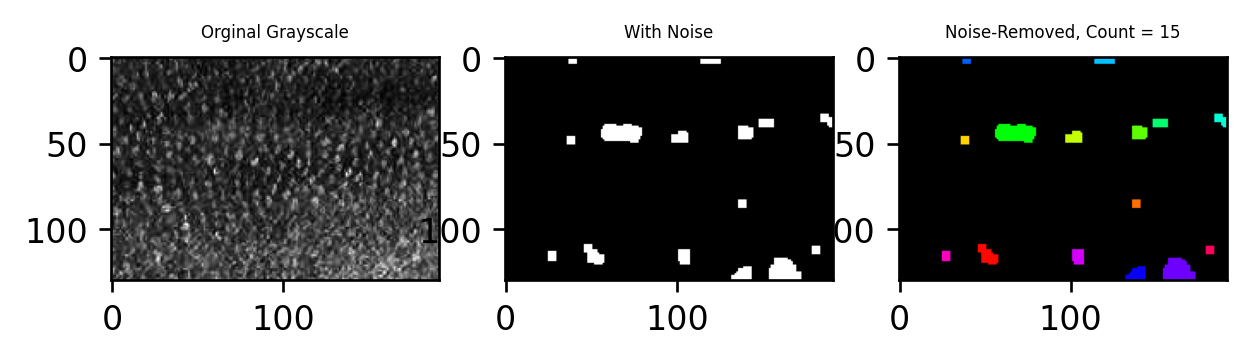

SUBIMAGE #1:

Original Image:
Blocksize, iterations: 65, 2
Size variation: 1.2428678596523497
Distribution: 5.516920329847341
Overall score: 3.3798940947498455

Inverted Image:
Blocksize, iterations: 65, 3
Size variation: 1.4313589669771978
Distribution: 9.839069973113386
Overall score: 5.635214470045292

Tried both original and inverted, but decided to keep original.


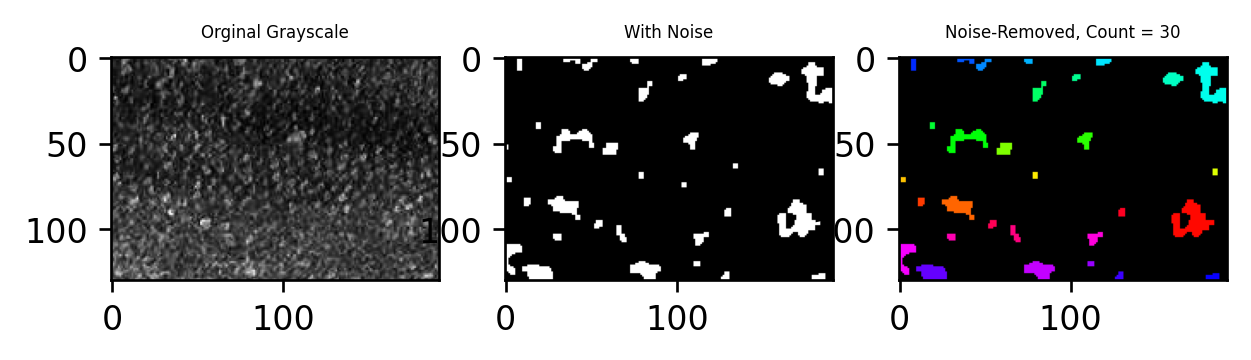

SUBIMAGE #2:

Original Image:
Blocksize, iterations: 65, 2
Size variation: 1.1817548252416066
Distribution: 7.195777111913975
Overall score: 4.1887659685777905

Inverted Image:
Blocksize, iterations: 85, 1
Found an edge scale that is more than 5 times the average size of non-edge scales.
Size variation: 100
Distribution: 11.784290048839436
Overall score: 55.89214502441972

Tried both original and inverted, but decided to keep original.


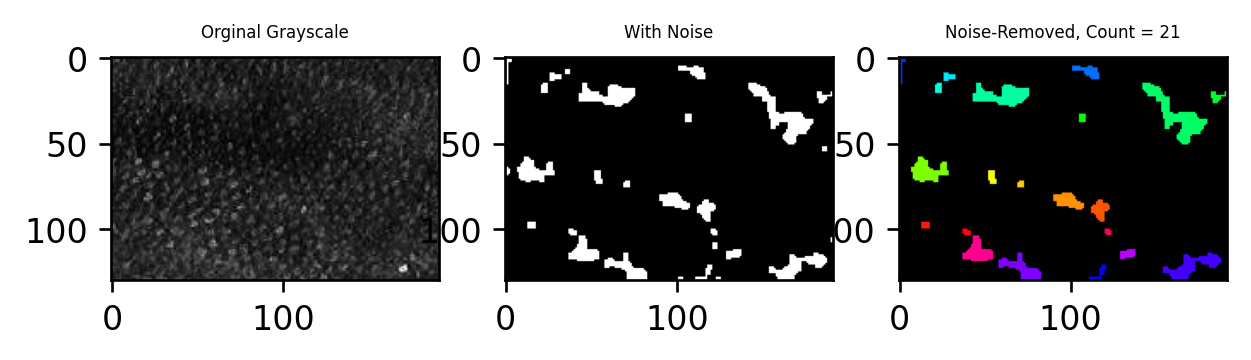

SUBIMAGE #3:

Original Image:
Blocksize, iterations: 65, 2
Found an edge scale that is more than 5 times the average size of non-edge scales.
Size variation: 100
Distribution: 4.118499502048761
Overall score: 52.05924975102438

Inverted Image:
Blocksize, iterations: 65, 2
Found an edge scale that is more than 5 times the average size of non-edge scales.
Size variation: 100
Distribution: 8.702412427798805
Overall score: 54.3512062138994
Could not find 1 subimages that pass the quality check.

Tried both original and inverted, but decided to keep original.


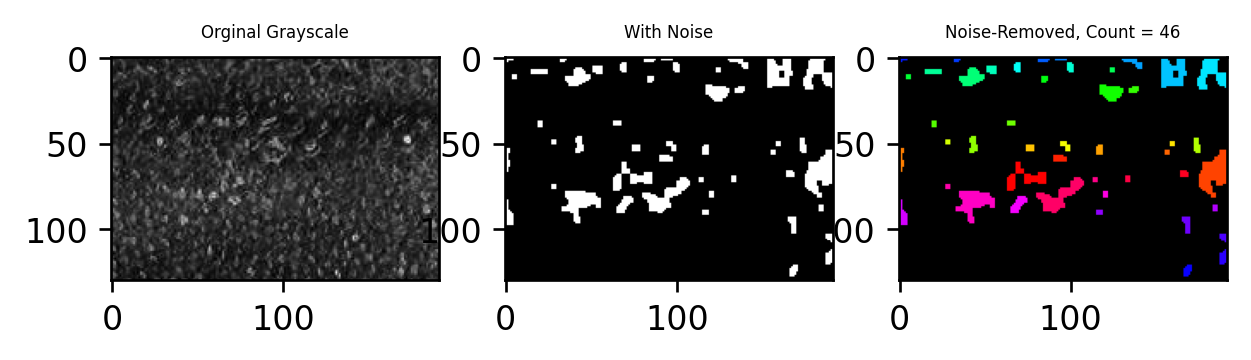

SUBIMAGE #4:

Original Image:
Blocksize, iterations: 65, 2
Size variation: 1.2298207106060535
Distribution: 6.669122447773113
Overall score: 3.949471579189583

Inverted Image:
Blocksize, iterations: 65, 2
Found an edge scale that is more than 5 times the average size of non-edge scales.
Size variation: 100
Distribution: 15.23582005395703
Overall score: 57.617910026978514

Tried both original and inverted, but decided to keep original.


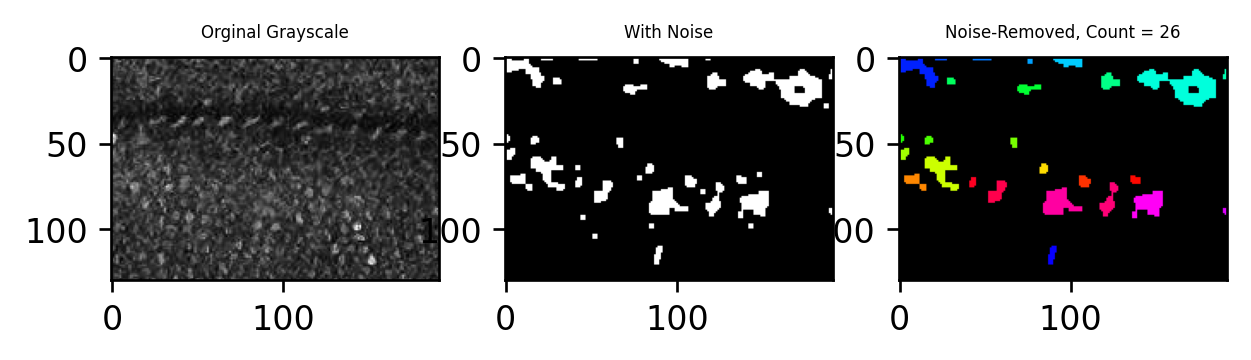

SUBIMAGE #5:

Original Image:
Blocksize, iterations: 15, 1
Size variation: 0.697237020105283
Distribution: 0.734968331787688
Overall score: 0.7161026759464855

Original image passed all tests; did not need to check inverted.


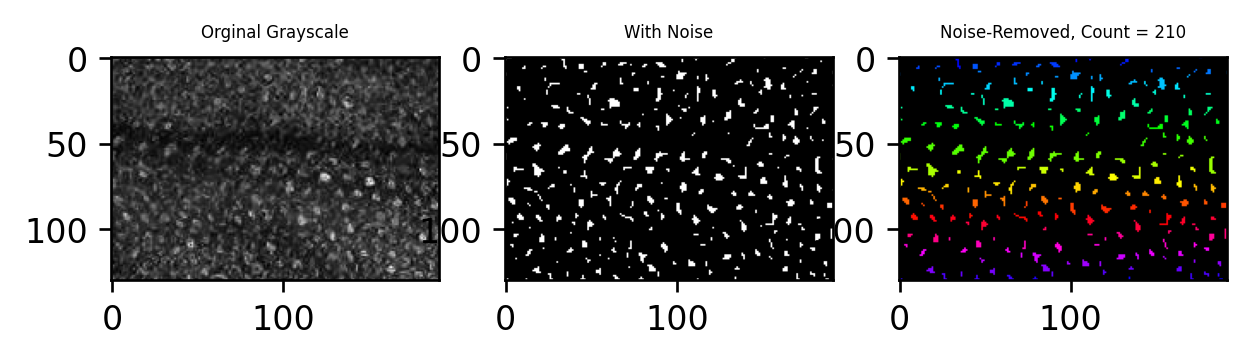

SUBIMAGE #6:

Original Image:
Blocksize, iterations: 15, 1
Size variation: 0.8409343715239154
Distribution: 0.5687026025351956
Overall score: 0.7048184870295555

Original image passed all tests; did not need to check inverted.


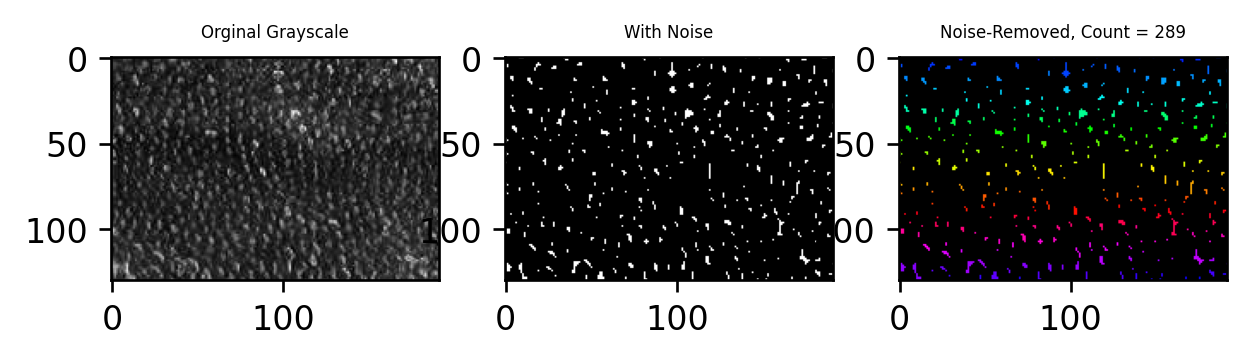

SUBIMAGE #7:

Original Image:
Blocksize, iterations: 15, 1
Size variation: 0.8331273820975044
Distribution: 0.6379842994128168
Overall score: 0.7355558407551606

Original image passed all tests; did not need to check inverted.


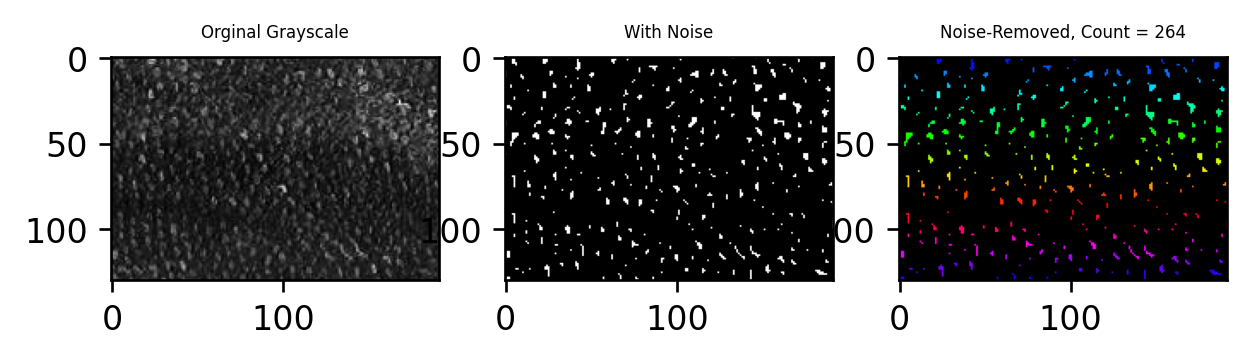

SUBIMAGE #8:

Original Image:
Blocksize, iterations: 15, 1
Size variation: 0.8702915387784506
Distribution: 0.5456113628222368
Overall score: 0.7079514508003437

Original image passed all tests; did not need to check inverted.


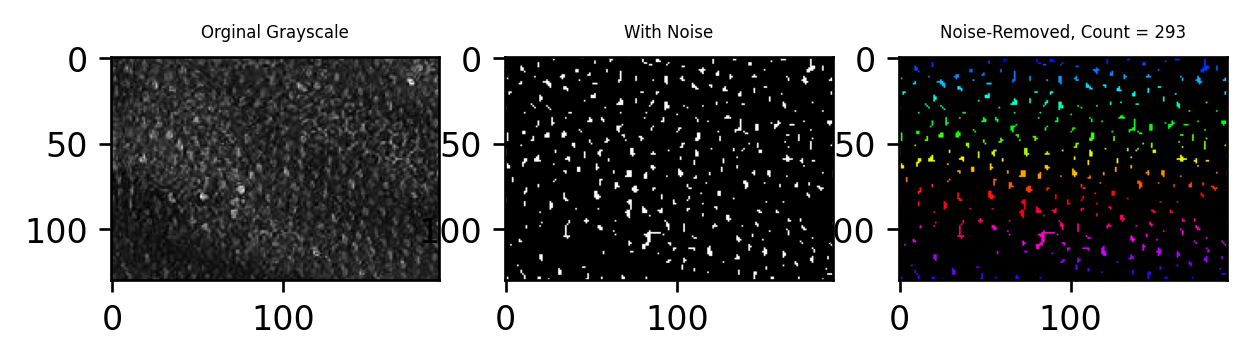


SELECTED SUBIMAGES: [5, 6, 8]


In [80]:
img_path = 'Large_images/117716_D_large_sample.png'
split_count_select(img_path, 3)